In [3]:
!pip install rasterio
!pip install --upgrade pandas

/Users/ethanhsiao/opt/anaconda3/lib/python3.7/site-packages/cryptography/hazmat/backends/openssl/x509.py:18: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  utils.DeprecatedIn35,
     |████████████████████████████████| 21.1 MB 748 kB/s eta 0:00:01     |████████████████████▏           | 13.3 MB 9.9 MB/s eta 0:00:01


In [15]:
import rasterio
import geopandas as gpd
from pathlib import Path
import asf_search as asf
from shapely.geometry import shape
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
place_aoi = gpd.read_file('/Users/ethanhsiao/Documents/ground-swath/data/shape.shp')

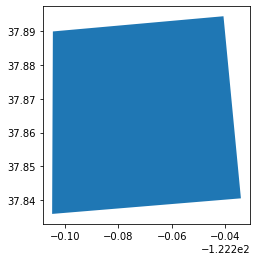

In [3]:
place_aoi.geometry.plot()

In [ ]:
#place_aoi_2 = gpd.read_file('/Users/ethanhsiao/Documents/ground-swath/data/shape2.shp')
#place_aoi_2.geometry.plot()

In [4]:
place_wkt = place_aoi.geometry.to_wkt()[0]

In [5]:
place_wkt

'POLYGON ((-122.25217442555794 37.86960413795028, -122.26579789511528 37.867987646118614, -122.26621579295447 37.87399157986792, -122.25652056308546 37.8753770335588, -122.25217442555794 37.86960413795028))'

In [6]:
opts = {
    'platform': 'S1', #asf.PLATFORM.SENTINEL1
    'start': '2019-01-01',
    'end': '2020-02-01',
    'maxResults': 100
    #'processingLevel': asf_search.PRODUCT_TYPE.RTC_HIGH_RES, processingLevel=asf.PRODUCT_TYPE.METADATA,
    #'polarization': asf_search.POLARIZATION.HH_HV,
    #'flightDirection': asf_search.FLIGHT_DIRECTION.ASCENDING
}

In [7]:
results = asf_search.geo_search(intersectsWith=place_wkt, **opts)
print(f'{len(results)} results found')

100 results found


In [8]:
#from Angela: splitting by platform S1A/S1B and ascending/descending flight direction
S1A = []
S1B = []
ascend_ID = []
descend_ID = []
for i in range(len(results)):
    if 'Sentinel-1A' in results[i].properties['platform']:
        S1A.append(i)
    else:
        S1B.append(i)
    if 'ASCENDING' in results[i].properties['flightDirection']:
        ascend_ID.append(i)
    else:
        descend_ID.append(i)
print(ascend_ID)
print(S1A)

[8, 9, 10, 11, 32, 33, 34, 35, 36, 37]
[38, 39, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 95, 96, 97, 98, 99]


Text(0.5, 1.0, 'Top 100 Sentinel 1 Observations')

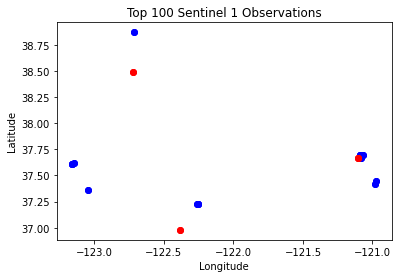

In [20]:
#latitude/longitude
latitude = []
longitude = []
for i in range(len(results)):
    if results[i].properties['centerLat']:
        latitude.append(float(results[i].properties['centerLat']))
    if results[i].properties['centerLat']:
        longitude.append(float(results[i].properties['centerLon']))
plt.figure('Observations')
plt.clf()
for i in range(len(latitude)):
    if i in ascend_ID:
        plt.scatter(longitude[i],latitude[i],c='red')
    else:
        plt.scatter(longitude[i],latitude[i],c='blue')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Top 100 Sentinel 1 Observations')

In [21]:
#processingLevel
metadata = []
raw = []
grd_hd = []

for i in range(len(results)):
    if 'METADATA_RAW' in results[i].properties['processingLevel']:
        metadata.append(i)
    elif 'GRD_HD' in results[i].properties['processingLevel']:
        grd_hd.append(i)
    else:
        raw.append(i)
raw[:10]

[1, 2, 3, 6, 7, 9, 11, 12, 13, 14]

In [22]:
#turn data into df
df = pd.DataFrame(
{
    'platform':[],
    'flightDirection':[],
    'centerLat':[],
    'centerLon':[],
    'processingLevel':[]
})
platformlist = []
flightlist = []
latlist = []
lonlist = []
processlist = []
for i in range(len(results)):
    platformlist.append(results[i].properties['platform'])
    flightlist.append(results[i].properties['flightDirection'])
    latlist.append(results[i].properties['centerLat'])
    lonlist.append(results[i].properties['centerLon'])
    processlist.append(results[i].properties['processingLevel'])
    
df.platform = platformlist
df.flightDirection = flightlist
df.centerLat = latlist
df.centerLon = lonlist
df.processingLevel = processlist

In [23]:
df.head()

,platform,flightDirection,centerLat,centerLon,processingLevel
0,Sentinel-1B,DESCENDING,37.4486,-120.9719,METADATA_RAW
1,Sentinel-1B,DESCENDING,37.4486,-120.9719,RAW
2,Sentinel-1B,DESCENDING,37.6937,-121.0714,METADATA_SLC
3,Sentinel-1B,DESCENDING,37.6937,-121.0714,SLC
4,Sentinel-1B,DESCENDING,37.6958,-121.0894,GRD_HD


In [24]:
#transform df into gdf
gdf = gpd.GeoDataFrame(df, 
                       geometry=gpd.points_from_xy(df.centerLon, df.centerLat))

In [25]:
gdf.head()

,platform,flightDirection,centerLat,centerLon,processingLevel,geometry
0,Sentinel-1B,DESCENDING,37.4486,-120.9719,METADATA_RAW,POINT (-120.97190 37.44860)
1,Sentinel-1B,DESCENDING,37.4486,-120.9719,RAW,POINT (-120.97190 37.44860)
2,Sentinel-1B,DESCENDING,37.6937,-121.0714,METADATA_SLC,POINT (-121.07140 37.69370)
3,Sentinel-1B,DESCENDING,37.6937,-121.0714,SLC,POINT (-121.07140 37.69370)
4,Sentinel-1B,DESCENDING,37.6958,-121.0894,GRD_HD,POINT (-121.08940 37.69580)


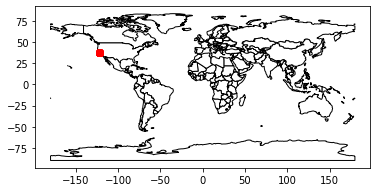

In [26]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(color='white', edgecolor='black')
gdf.plot(ax=ax, color='red')
plt.show()